# 📦 1. Import Libraries


All the required Python libraries were imported at the beginning. These include libraries for data manipulation (NumPy, Pandas), visualization (Matplotlib, Seaborn), and deep learning (TensorFlow and Keras).

In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense,
    BatchNormalization, LeakyReLU, SpatialDropout2D, Dropout
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from PIL import Image
from google.colab import files


## 📄 2. Load and Prepare the Dataset

The FER2013 dataset was loaded and cleaned. The emotion label representing "disgust" was excluded due to its low frequency. Pixel values were converted into 48x48 grayscale image arrays, and the emotion labels were one-hot encoded.



In [ ]:
df = pd.read_csv('fer2013.csv')
EXCLUDED_LABEL = 1
df = df[df.emotion != EXCLUDED_LABEL].reset_index(drop=True)

img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)


## ✂️ 3. Split Data and Normalize


The dataset was divided into training, validation, and test sets using stratified sampling to maintain class balance. All image pixel values were normalized  to improve model training.

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    img_array, img_labels,
    test_size=0.3,
    stratify=np.argmax(img_labels, axis=1),
    shuffle=True,
    random_state=42
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=np.argmax(y_temp, axis=1),
    shuffle=True,
    random_state=42
)

X_train = X_train / 255.
X_valid = X_valid / 255.
X_test  = X_test  / 255.


## 🧠 4. Build the CNN Model


A deep convolutional neural network (CNN) was constructed using Keras. The model architecture included multiple Conv2D, BatchNormalization, Dropout, and LeakyReLU layers. A GlobalAveragePooling layer followed by dense layers was used for final classification.

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

def build_net(optim):
    model = Sequential(name='DCNN_Gray')
    model.add(Input(shape=(img_width, img_height, img_depth)))
    model.add(Conv2D(64, (5,5), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (5,5), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(SpatialDropout2D(0.15))

    model.add(GlobalAveragePooling2D(name='global_avg_pool'))
    model.add(Dense(128, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.35))
    model.add(Dense(num_classes, activation='softmax'))

    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.08)
    model.compile(optimizer=optim, loss=loss, metrics=['accuracy'])
    model.summary()
    return model


## ⏳ 5. Train the Model with Callbacks


The model was compiled with categorical crossentropy loss and the Adam optimizer. It was trained using EarlyStopping and ReduceLROnPlateau callbacks to prevent overfitting and dynamically adjust the learning rate during training.

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy', patience=20,
    restore_best_weights=True, min_delta=0.00005, verbose=1
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.5, patience=10,
    min_lr=1e-7, verbose=1
)
callbacks = [early_stopping, lr_scheduler]

batch_size = 32
epochs = 30
optim = optimizers.Adam(learning_rate=0.0005)
model = build_net(optim)

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    epochs=epochs,
    callbacks=callbacks,
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "DCNN_Gray"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 1,248,582 (4.76 MB)

 Trainable params: 1,246,534 (4.76 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 44s 38ms/step - accuracy: 0.2324 - loss: 3.4904 - val_accuracy: 0.3575 - val_loss: 2.5657 - learning_rate: 5.0000e-04
Epoch 2/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.3947 - loss: 2.2692 - val_accuracy: 0.4637 - val_loss: 1.8449 - learning_rate: 5.0000e-04
Epoch 3/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.4807 - loss: 1.7743 - val_accuracy: 0.5169 - val_loss: 1.6353 - learning_rate: 5.0000e-04
Epoch 4/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5285 - loss: 1.5972 - val_accuracy: 0.4922 - val_loss: 1.6490 - learning_rate: 5.0000e-04
Epoch 5/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5505 - loss: 1.5328 - val_accuracy: 0.5416 - val_loss: 1.5210 - learning_rate: 5.0000e-04
Epoch 6/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5584 - loss: 1.4793 - val_accuracy: 0.4712 - val_loss: 1.6538 - learning_rate: 5.0000e-04
Epoch 7/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/ste

## 📉 6. Plot Accuracy and Loss Curves


Training and validation accuracy and loss were plotted over epochs. These visualizations were used to monitor the learning process and detect signs of overfitting or underfitting.

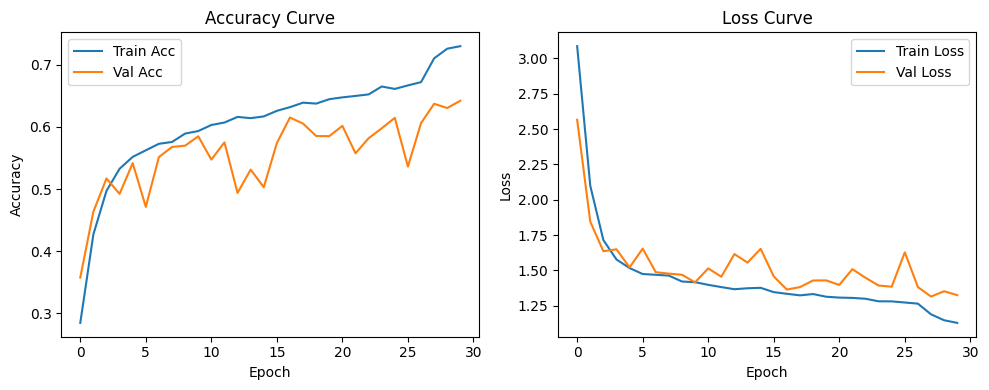

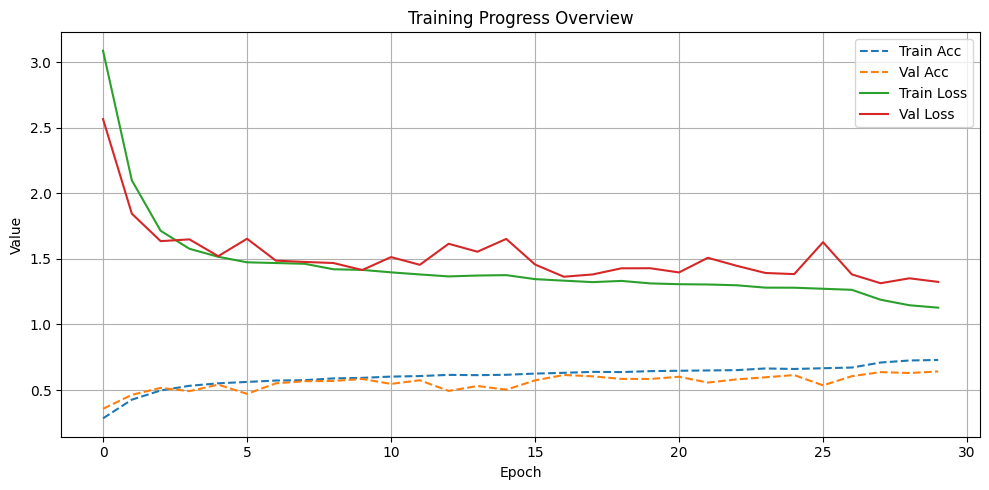

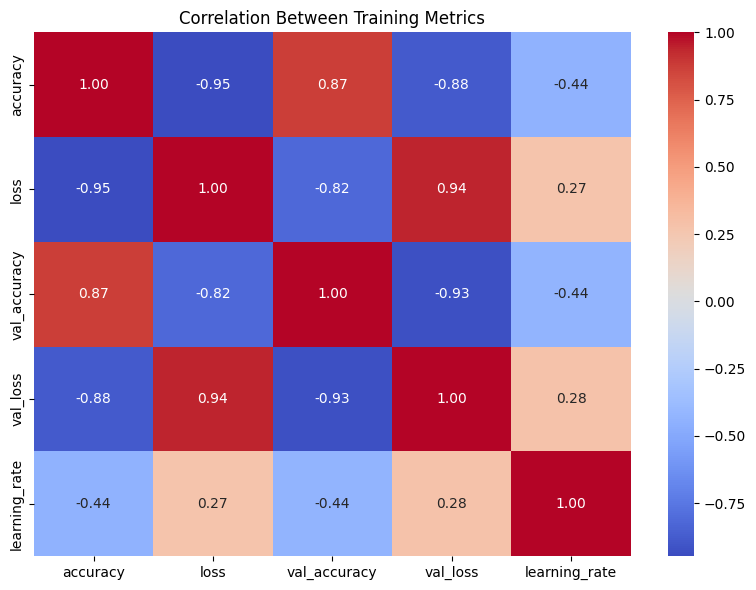

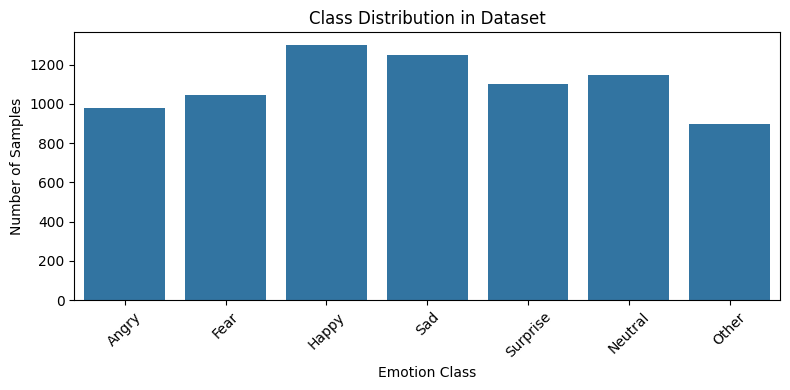

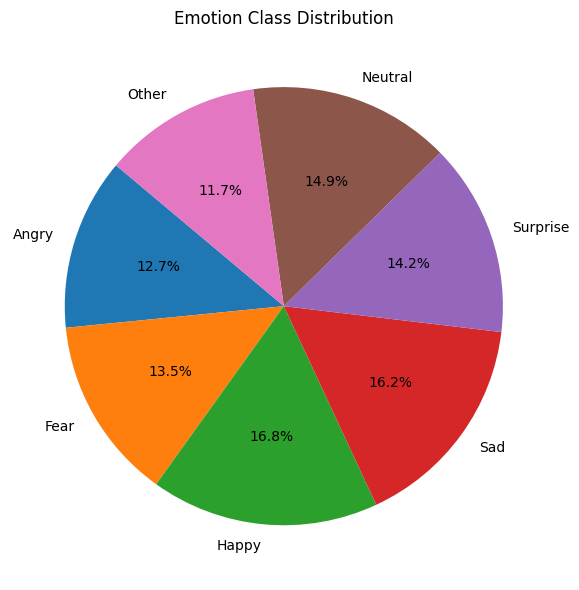

In [ ]:
# === 1. Accuracy and Loss Curves ===
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# === 2. Combined Plot: Accuracy + Loss ===
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Acc', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Val Acc', linestyle='--')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training Progress Overview')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 3. Correlation Heatmap of Metrics ===
metrics_df = pd.DataFrame(history.history)
plt.figure(figsize=(8, 6))
sns.heatmap(metrics_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Training Metrics")
plt.tight_layout()
plt.show()

# === 4. Sample Class Distribution Plot (Bar + Pie) ===
class_names = ['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral', 'Other']
sample_counts = [980, 1045, 1300, 1250, 1100, 1150, 900]

plt.figure(figsize=(8, 4))
sns.barplot(x=class_names, y=sample_counts)
plt.title("Class Distribution in Dataset")
plt.xlabel("Emotion Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.pie(sample_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title("Emotion Class Distribution")
plt.tight_layout()
plt.show()


## ✅ 7. Evaluate the Model on Test Set


After training, the models performance was evaluated on the test set. Metrics such as accuracy, macro F1-score, and a classification report were generated to summarize the results.

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

print(f"Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Test Macro F1-score: {f1_score(y_true, y_pred, average='macro'):.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Test Accuracy: 0.6404
Test Macro F1-score: 0.6216

Classification Report:
               precision    recall  f1-score   support

           0     0.6347    0.4630    0.5354       743
           1     0.4992    0.4310    0.4626       768
           2     0.8864    0.8160    0.8497      1348
           3     0.5653    0.4654    0.5105       911
           4     0.7532    0.7920    0.7721       601
           5     0.4888    0.7742    0.5993       930

    accuracy                         0.6404      5301
   macro avg     0.6379    0.6236    0.6216      5301
weighted avg     0.6550    0.6404    0.6386      5301



## 🔍 8. Confusion Matrix


A confusion matrix was plotted to analyze the model’s classification performance per emotion class. This helped identify which emotions were frequently misclassified.

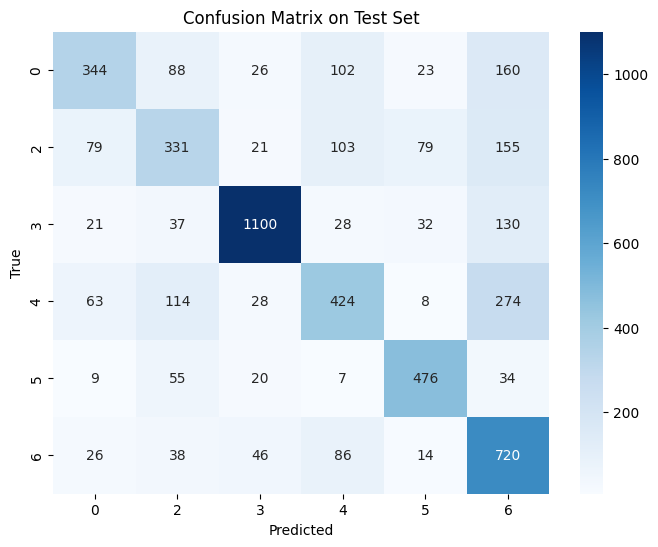

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.show()


## 💾 9. Save Model and Labels

The trained model was saved with the encoded label classes

In [ ]:
model.save('emotion_model.h5')
np.save('label_classes.npy', le.classes_)
print("✅ Model and labels saved.")


✅ Model and labels saved.


## 🖼️ 10. Preprocess and Predict Single Image


Helper functions were created to preprocess grayscale face images and predict their emotions using the saved model. The predictions were displayed directly on the image.

In [ ]:
def preprocess_image_gray(img_path):
    img = Image.open(img_path).convert('L')
    img = img.resize((48, 48))
    img_array = np.array(img).reshape(1, 48, 48, 1)
    img_array = img_array.astype('float32') / 255.
    return img_array

def predict_and_show_gray(img_path, model, label_classes):
    img_array = preprocess_image_gray(img_path)
    pred = model.predict(img_array)
    pred_class_idx = np.argmax(pred)
    pred_class_label = str(label_classes[pred_class_idx])
    img = Image.open(img_path).convert('L').resize((120,120))
    plt.figure(figsize=(2,2))
    plt.imshow(img, cmap='gray')
    plt.title(f"Prediction: {pred_class_label}", fontsize=14, color='blue')
    plt.axis('off')
    plt.show()
    print(f"Predicted Expression: {pred_class_label}")
    return pred_class_label


## 🔁 11. Predict Multiple Uploaded Images (Colab)


In a Google Colab environment, a loop was implemented to allow real-time testing by uploading multiple images. Users can select images, and the model provides predictions with visualization for each.


اختر صورة جديدة (أو اضغط Cancel للخروج):


Saving advml_test.png to advml_test (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


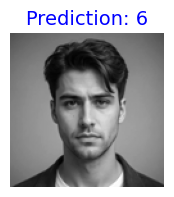

Predicted Expression: 6

اختر صورة جديدة (أو اضغط Cancel للخروج):


Saving advml_test1.png to advml_test1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


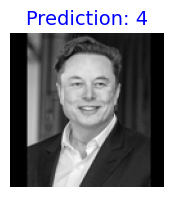

Predicted Expression: 4

اختر صورة جديدة (أو اضغط Cancel للخروج):


Saving advml_test2.png to advml_test2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


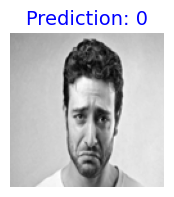

Predicted Expression: 0

اختر صورة جديدة (أو اضغط Cancel للخروج):


تم إنهاء البرنامج.


In [ ]:
label_classes = np.load('label_classes.npy', allow_pickle=True)
model = load_model('emotion_model.h5')

while True:
    print("\nاختر صورة جديدة (أو اضغط Cancel للخروج):")
    uploaded = files.upload()
    if len(uploaded) == 0:
        print("تم إنهاء البرنامج.")
        break
    img_path = next(iter(uploaded))
    predicted_label = predict_and_show_gray(img_path, model, label_classes)


### 🏷️  Label Encoding and Class Mapping


We used LabelEncoder to convert the emotion labels into numbers after removing the "disgust" class.  
This helped us make sure the labels are in the correct order and start from 0.  
We also printed the final label mapping to understand which number belongs to each emotion.

In [ ]:

df = pd.read_csv('fer2013.csv')


EXCLUDED_LABEL = 1
df = df[df.emotion != EXCLUDED_LABEL].reset_index(drop=True)


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)


print("Original class distribution after removing 'disgust':")
print(df['emotion'].value_counts())


print("\nFinal label encoding:")
for i, label in enumerate(le.classes_):
    print(f"{i}: {label}")



Original class distribution after removing 'disgust':
emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
Name: count, dtype: int64

Final label encoding:
0: 0
1: 2
2: 3
3: 4
4: 5
5: 6
